In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14

## Defining the Boltzmann machine model inside an object 

In [2]:
class boltzmanmachine:
    
    def __init__(self, N, L, M, sigma, De, vmin, spin=True):
        self.w = np.random.normal(loc=0.0, scale=sigma, size=(L,M))
        self.a = np.random.normal(loc=0.0, scale=sigma, size=L)
        self.b = b = np.zeros(M)
        
        
        self.w = sigma * np.random.randn(L,M)
        self.a = sigma * np.random.randn(L)
        self.b = b = np.zeros(M)
        
        self.spin=spin
        
        self.DE = De
        self.N = int(N)
        self.L = int(L)
        self.M = int(M)
        self.vmin=vmin
        
        self.v_data, self.v_model = None, None
        self.h_data, self.h_model = None, None
        self.vh_data,self.vh_model= None, None
        
        if self.spin:
            self.csi1 = np.array([1,-1,-1,-1])    
            self.csi2 = np.array([-1,1,-1,-1])   
            self.csi3 = np.array([-1,-1,1,-1])    
            self.csi4 = np.array([-1,-1,-1,1])  
        else:
            self.csi1 = np.array([1,0,0,0])    
            self.csi2 = np.array([0,1,0,0])   
            self.csi3 = np.array([0,0,1,0])    
            self.csi4 = np.array([0,0,0,1]) 
            
        

        self.csi = [self.csi1, self.csi2, self.csi3, self.csi4]
        
        #algotithm variables
        self.sa_t0 = 0
        self.sb_t0 = 0
        self.sw_t0 = 0
        
        self.ma_t0 = 0
        self.mb_t0 = 0
        self.mw_t0 = 0
        
        
    def init_avg(self):
        self.v_data, self.v_model = np.zeros(self.L),np.zeros(self.L)
        self.h_data, self.h_model = np.zeros(self.M),np.zeros(self.M)
        self.vh_data,self.vh_model= np.zeros((self.L,self.M)),np.zeros((self.L,self.M))
        
        
        
    def positive(self, v_in, Amp=1.):
        act = np.dot(v_in, self.w) + self.b      
        #print(act)
        argument=np.exp(-Amp*self.DE*act)
        prob = 1. / (1. + argument)
        n = np.shape(act)
        h = np.full(n, self.vmin, dtype=int) # a list on -1's or 0's
        h[np.random.random_sample(n) < prob] = 1
        
        return h
    
    def neg(self, h_in, Amp=1.):
        act = np.dot(h_in, self.w.T) + self.a      
        #print(act)
        prob = 1. / (1. + np.exp(-Amp*self.DE*act))
        n = np.shape(act)
        vf = np.full(n, self.vmin, dtype=int) # a list on -1's or 0's
        vf[np.random.random_sample(n) < prob] = 1
        
        return vf
    
    
    def negative(self, h_in, Amp=1.):
        
        weigths = np.reshape(np.dot(h_in, self.w.T) + self.a, (5,4) ) 

        
        E1 = np.dot(weigths, self.csi1) #array of length 5, the number of amminoacids
        E2 = np.dot(weigths, self.csi2)
        E3 = np.dot(weigths, self.csi3)
        E4 = np.dot(weigths, self.csi4)
        


        Z = np.exp(-Amp*E1) + np.exp(-Amp*E2) + np.exp(-Amp*E3) + np.exp(-Amp*E4) #partition function for each amminoacid
        
        p1 = np.exp(-Amp*E1)/Z 
        p2 = np.exp(-Amp*E2)/Z
        p3 = np.exp(-Amp*E3)/Z
        p4 = np.exp(-Amp*E4)/Z
        
        
        
        p = np.reshape(np.concatenate((p1, p2, p3, p4)), (4, 5))      

        
        cum = np.cumsum(p, axis=0) #(4x5) containing the comulatives  
        r = np.random.random(size=5)        
        
        mask = cum < r    
        indx = []    
        
        for i in range(mask.shape[1]):
            __, index = np.unique(mask[:, i], return_index=True)
            indx.append(index[0])
            
        vf=np.concatenate((self.csi[indx[0]], self.csi[indx[1]], self.csi[indx[2]], self.csi[indx[3]], self.csi[indx[4]]))
        return vf
        
    
    def update_vh(self, v_k, vf, h, hf):
        self.v_data  += v_k
        self.v_model += vf
        self.h_data  += h
        self.h_model += hf
        self.vh_data += np.outer(v_k.T,h)
        self.vh_model+= np.outer(vf.T,hf)
    
    def SGD(self, l_rate):
        dw = l_rate_m*(self.vh_data - self.vh_model)
        da = l_rate_m*(self.v_data - self.v_model)
        db = l_rate_m*(self.h_data - self.h_model)
        
        self.w += dw
        self.a += da
        self.b += db
        
    def RMSprop(self, eta_t, beta=0.9, epsilon=1e-8):
        
        ga_t = self.v_data - self.v_model
        gb_t = self.h_data - self.h_model
        gw_t = self.vh_data - self.vh_model
        
        sa_t = beta*self.sa_t0 + (1-beta)*ga_t**2
        sb_t = beta*self.sb_t0 + (1-beta)*gb_t**2
        sw_t = beta*self.sw_t0 + (1-beta)*gw_t**2
        
        self.sa_t0 = sa_t
        self.sb_t0 = sb_t
        self.sw_t0 = sw_t
        
        
        self.a = self.a + eta_t*ga_t/np.sqrt(sa_t + epsilon)
        self.b = self.b + eta_t*gb_t/np.sqrt(sb_t + epsilon)
        self.w = self.w + eta_t*gw_t/np.sqrt(sw_t + epsilon)
        
        
    def ADAM(self, eta_t, epoch, beta1=0.9, beta2=0.99,epsilon=1e-8):
        ga_t = self.v_data - self.v_model
        gb_t = self.h_data - self.h_model
        gw_t = self.vh_data - self.vh_model

        ma_t = beta1*self.ma_t0 + (1-beta1)*ga_t
        mb_t = beta1*self.mb_t0 + (1-beta1)*gb_t
        mw_t = beta1*self.mw_t0 + (1-beta1)*gw_t

        sa_t = beta2*self.sa_t0 + (1-beta2)*ga_t**2
        sb_t = beta2*self.sb_t0 + (1-beta2)*gb_t**2
        sw_t = beta2*self.sw_t0 + (1-beta2)*gw_t**2

        self.sa_t0 = sa_t
        self.sb_t0 = sb_t
        self.sw_t0 = sw_t

        self.ma_t0 = ma_t
        self.mb_t0 = mb_t
        self.mw_t0 = mw_t

        ma_t_hat = ma_t/(1-beta1**epoch) 
        mb_t_hat = mb_t/(1-beta1**epoch) 
        mw_t_hat = mw_t/(1-beta1**epoch)

        sa_t_hat = sa_t/(1-beta2**epoch) 
        sb_t_hat = sb_t/(1-beta2**epoch) 
        sw_t_hat = sw_t/(1-beta2**epoch)

        self.a = self.a + eta_t*ma_t_hat/(np.sqrt(sa_t_hat) + epsilon)
        self.b = self.b + eta_t*mb_t_hat/(np.sqrt(sb_t_hat) + epsilon)
        self.w = self.w + eta_t*mw_t_hat/(np.sqrt(sw_t_hat) + epsilon)
    

## Defining global variable which will control the training process

In [3]:
seed = 1
Amp  = 0.05
cdn  = 1.
epochs = 100

## Importing data and pre-process them in order to switch from bit to spins

In [4]:
CASE=1
if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"

fname=dname+'/x_RBM_q0.1.dat'
# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1])

SPINS = True
#SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
print('...')

each of N=10000 data has L=20 digits
[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0] 
-> [-1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1] 
-> [-1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1]
[0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1] 
-> [-1 -1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1]
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0] 
-> [-1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1  1 -1  1 -1 -1 -1]
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0] 
-> [-1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1]
[0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0] 
-> [-1 -1 -1  1 -1  1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1]
[0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0] 
-> [-1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1] 
-> [-1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1]
[1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0] 
-> [ 1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1  1 -

In [5]:
# RBM, nr of hidden units
if CASE==0: M = 3
if CASE==1: M = 6
# range of each initial weight

sigma = np.sqrt(4. / float(L + M))
# random seed for reproducibility

np.random.seed(seed)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
rbm = boltzmanmachine(N,L,M,sigma,GAP, vmin, spin=SPINS)

print("w=",rbm.w);print("a=",rbm.a);print("b=",rbm.b)
w0,a0,b0=np.copy(rbm.w),np.copy(rbm.a),np.copy(rbm.b)

w= [[-7.31786852e-02 -3.99080146e-02  3.40805190e-01  2.94335661e-01
   2.07673386e-01  5.40108582e-02]
 [ 3.05239577e-02  2.42548694e-01  9.11918688e-02  2.67718688e-01
  -1.21637806e-01 -9.55021944e-01]
 [ 4.07460532e-01  8.57803992e-01  1.73117378e-01 -3.92841145e-02
  -5.35180317e-02 -4.66968944e-02]
 [ 6.82853174e-03 -4.40091953e-01 -2.02821133e-01 -3.91066096e-01
   9.75870599e-02 -1.16352233e-01]
 [ 1.94237862e-01 -6.85242170e-02  3.86872490e-01  8.37548869e-02
   8.59263128e-01 -7.43813950e-01]
 [-2.53741601e-01  3.53592250e-01  9.91690932e-01 -9.75225833e-02
   1.71283883e-02 -8.87677491e-02]
 [ 5.22240446e-01 -1.12691416e-01  2.66745337e-01 -1.25436507e-01
  -4.99138610e-01  1.22983534e-01]
 [ 1.97365322e-01  5.07244924e-01 -4.33208879e-02 -2.42149324e-01
   2.20733063e-01  9.44248562e-02]
 [ 1.10085900e-01 -2.86771618e-02  4.55122232e-01  1.44926967e-01
   7.47068609e-01  4.35792291e-01]
 [ 2.58500598e-01 -6.38333835e-01  2.36249059e-01  1.64848243e-01
   3.18081416e-01  4.0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1]


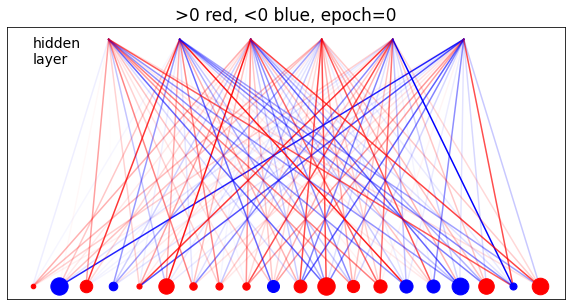

In [6]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch, w, M, a, b):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()
                  
plotgraph(0, rbm.w, M, rbm.a, rbm.b)

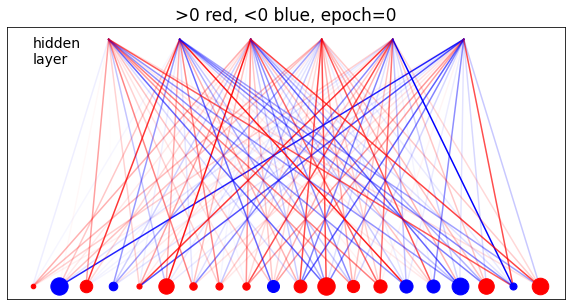

0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05


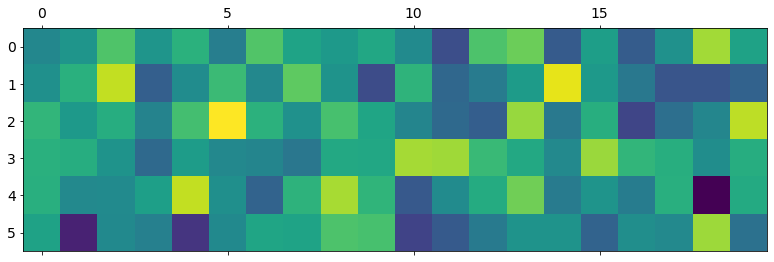

10
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05


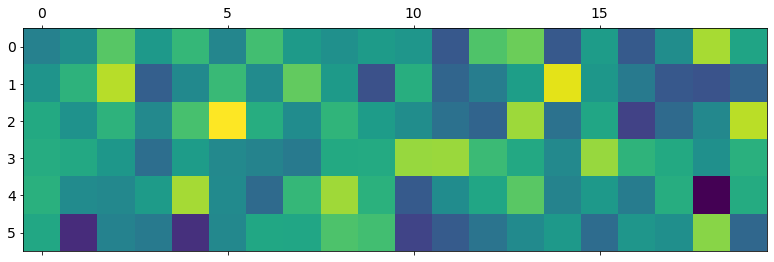

20
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05


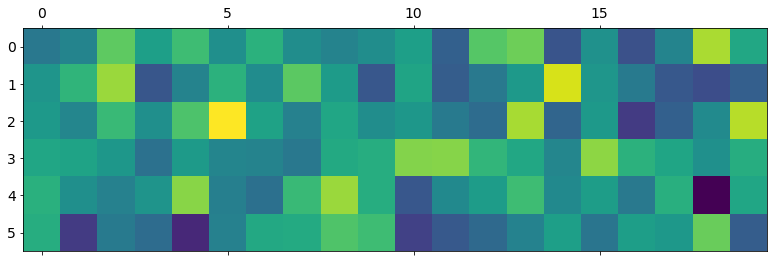

30
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05


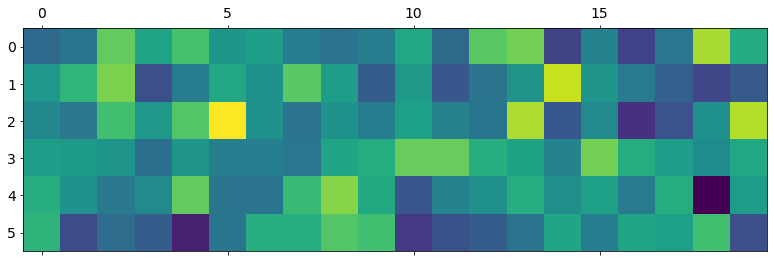

40
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05


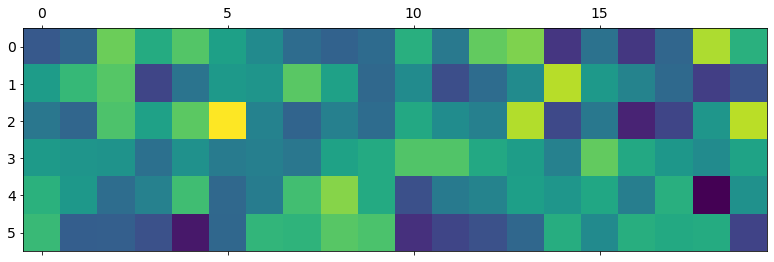

50
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05


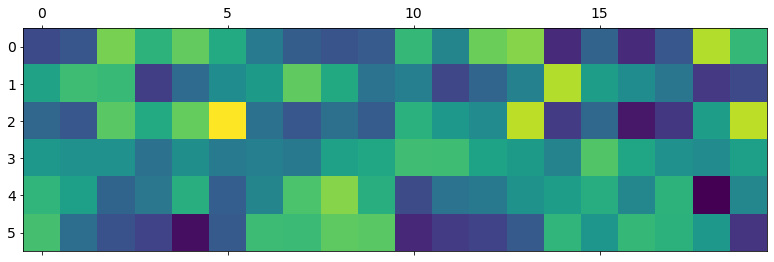

60
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05


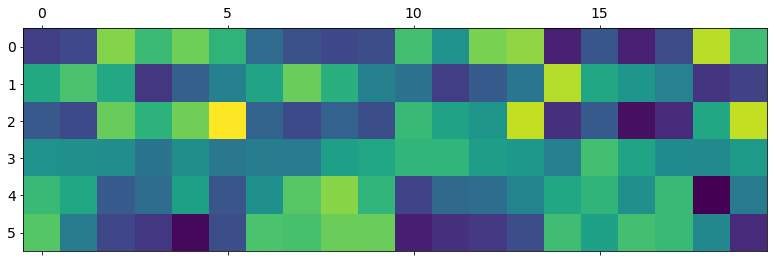

70
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05


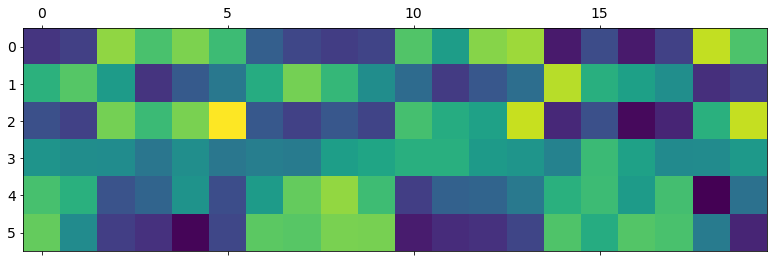

80
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05


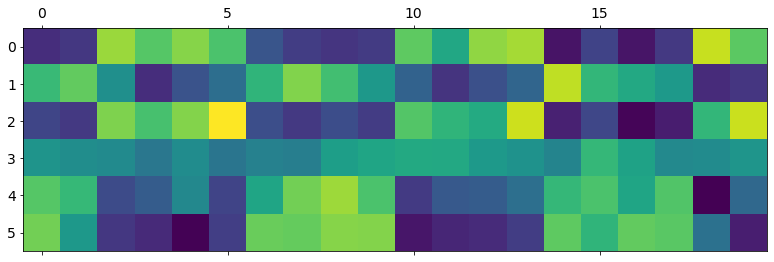

90
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05


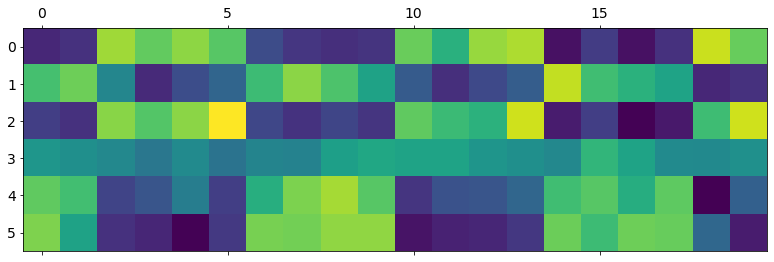

100


In [7]:
# random seed for reproducibility
np.random.seed(seed)
plotgraph(0, rbm.w, M, rbm.a, rbm.b)

# learning rate
l_rate = 5e-1

# minibatch
mini, m = 500, 0

# train model
print('===================================================')
for epoch in range(epochs):
    # aggregate normalization of batch statistics and learning rate
    l_rate_m = l_rate / mini
    for k in range(N):
        if m==0:
            # initialize averages in miniblock
            rbm.init_avg()

        vf = np.copy(v[k])
        for i in np.arange(cdn):
            # positive CD phase: generating h 
            h = rbm.positive(vf, Amp)
            # negative CD phase: generating fantasy vf
            vf = rbm.negative(h, Amp)
        # one more positive CD phase: generating fantasy h from fantasy vf 
        hf = rbm.positive(vf, Amp)

        rbm.update_vh(v[k], vf, h, hf)
        
    
        m += 1
        # minibatch
        if m==mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            
            #rbm.ADAM(l_rate_m, epoch+1)
            #rbm.SGD(l_rate_m)
            rbm.RMSprop(l_rate_m)
            m=0
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    #l_rate = l_rate / (0.01 * l_rate + 1)
    #Amp += (0.5-0.05)/epochs
    print(Amp)
    if epoch%10==9:
        plt.matshow(rbm.w.T)
        plt.show()
        print(epoch+1)
#         plotgraph(epoch+1, rbm.w, M, rbm.a, rbm.b )
#         print('l_rate = ',l_rate)

In [8]:
from IPython.display import display_html 
import pandas as pd

ampl=Amp

# original, non-reshuffled data in v0
v1 = np.zeros_like(v0)
for k in range(N):
    # positive CD phase: generating h 
    h = rbm.positive(v0[k],ampl)
    # negative CD phase: generating fantasy vf with low T == large GAP
    v1[k] = rbm.negative(h,ampl)
# difference between fantasy and data
diff = (v1 - v0)/2
str0 = fname+'_M'+str(M)+'-mini'+str(mini)
np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')  


def is_one(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: gold;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

N1=12
df0 = pd.DataFrame(v0[:N1])
df1 = pd.DataFrame(((v1[:N1]-vmin)/(1-vmin)).astype(int))

df0s = df0.style.set_table_attributes("style='display:inline'")
df1s = df1.style.set_table_attributes("style='display:inline'")
df0s.applymap(is_one)
df1s.applymap(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)
df1s.set_caption('Denoised').set_table_styles(sty)

display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
7,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


In [9]:
ampl=0.5

v1 = np.zeros_like(v0)
for k in range(N):
    # positive CD phase: generating h 
    h = rbm.positive(v0[k],ampl)
    # negative CD phase: generating fantasy vf with low T == large GAP
    v1[k] = rbm.negative(h,ampl)
    

In [10]:
#import function for the table output
from tabulate import tabulate

#function that returns P if an AA is Polar and A if an AA is Apolar
def aa_type(aa):
    if np.sum(aa*[1,1,0,0]>0):
        return "P"
    else:
        return "A"

#function that analyse the polarity of a matrix of AAs
def results_plot(v):
    #the function i written in the 0-1 formalism
    if SPINS:
        v=(v+1)/2
        
    np.random.shuffle(v) #shuffle the data
    
    list_aa=[]
    
    #variables for the error
    err_count=0
    
    
    #calculation of the polarity and the error
    for i in range(len(v)):
        prec_aa='N'
        for j in range(5):
            aa=v[i, 4*j : 4*j+4]
            aa=aa_type(aa)
            list_aa.append(aa)
            if(aa==prec_aa):
                err_count+=1
            prec_aa=aa
        
    #print of the errors           
    print('Number of error:', err_count)
    print('Number of couple:', 4*len(v))
    print('Percentage of error:', err_count/(4*len(v))*100, '%')
    
    out=np.reshape(np.array(list_aa), (len(v), 5))
    
    # Generate the table with results
    table = tabulate(out[1:10, :], tablefmt="fancy_grid")
    
    print(table)
   

results_plot(v1)

Number of error: 177
Number of couple: 40000
Percentage of error: 0.4425 %
╒═══╤═══╤═══╤═══╤═══╕
│ P │ A │ P │ A │ P │
├───┼───┼───┼───┼───┤
│ A │ P │ A │ P │ A │
├───┼───┼───┼───┼───┤
│ P │ A │ P │ A │ P │
├───┼───┼───┼───┼───┤
│ A │ P │ A │ P │ A │
├───┼───┼───┼───┼───┤
│ A │ P │ A │ P │ A │
├───┼───┼───┼───┼───┤
│ P │ A │ P │ A │ P │
├───┼───┼───┼───┼───┤
│ P │ A │ P │ A │ P │
├───┼───┼───┼───┼───┤
│ P │ A │ P │ A │ P │
├───┼───┼───┼───┼───┤
│ A │ P │ A │ P │ A │
╘═══╧═══╧═══╧═══╧═══╛


In [11]:
df=pd.DataFrame((v1-vmin)/(1-vmin)).astype('int')
v1=np.array((v1-vmin)/(1-vmin), dtype=int)
error=np.zeros(len(df))
print(sum(error))
for i in range(len(df)):
    amminoacids = np.reshape(np.array(df.loc[i]), (5,4))
    for a in range(4):
        if list(np.where(amminoacids[a,:]))[0][0] <2 and list(np.where(amminoacids[a+1,:]))[0][0] <2 :
            error[i]=1
        elif list(np.where(amminoacids[a,:]))[0][0] >1 and list(np.where(amminoacids[a+1,:]))[0][0] >1:
            error[i]=1
print(sum(error)*100/len(df),'%')

0.0
0.9 %


In [12]:
v = ((v1-vmin)/(1-vmin))
v = np.sum(v, axis=0)
print(np.reshape((v/100), (5, 4)).sum(axis=0))

[333.205 292.38  319.36  305.055]


In [13]:
v_data = np.sum(v0, axis=0)
print(v_data/100)

[24.17 25.27 25.19 25.37 24.89 25.78 24.87 24.46 24.38 25.14 25.37 25.11
 25.   25.48 24.84 24.68 25.08 24.51 25.26 25.15]
